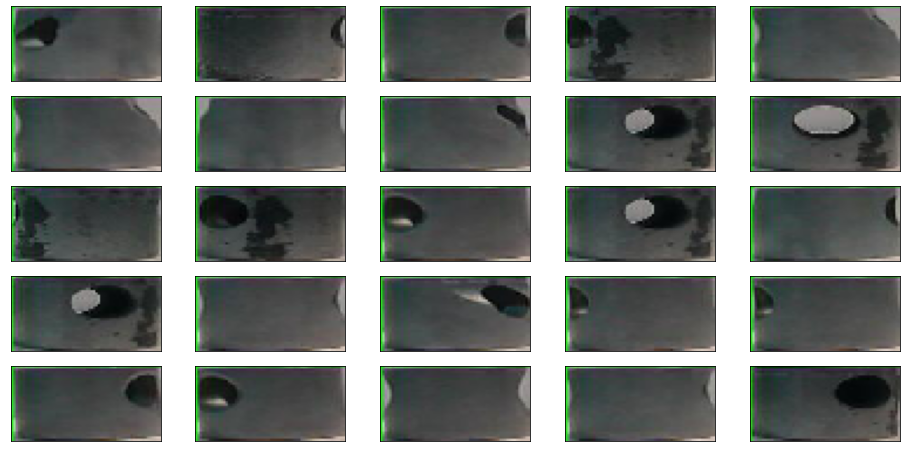

In [1]:
# This function plots images from a folder. 

import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

def plot_images(source_path):
    files=[]
    classes = glob.glob(source_path + '/*')
    for class_path in classes:
        files.extend([f for f in glob.glob(class_path + "/*", recursive=True)])
    random.shuffle(files)
    plt.figure(figsize=(16, 8))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        img = image.load_img(files[i], target_size=(32, 64))
        plt.imshow(img, cmap=plt.cm.binary)
    plt.show()
    
plot_images('data/train_data')

In [2]:
IMG_HEIGHT = 80
IMG_WIDTH = 80

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255)
train_data_gen = train_image_generator.flow_from_directory(directory='data/train_data',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 228 images belonging to 3 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential([
    Dense(24, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Flatten(),
    Dense(3)
])

In [4]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001),
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80, 80, 24)        96        
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense_1 (Dense)             (None, 3)                 460803    
                                                                 
Total params: 460,899
Trainable params: 460,899
Non-trainable params: 0
_________________________________________________________________


/home/studio-lab-user/.conda/envs/test_env/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
history = model.fit_generator(train_data_gen, epochs=10)

Epoch 1/10


<ipython-input-5-55e2693b2dae>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data_gen, epochs=10)


8/8 [==============================] - 1s 35ms/step - loss: 3.6726 - accuracy: 0.3904
Epoch 2/10
8/8 [==============================] - 0s 34ms/step - loss: 1.8759 - accuracy: 0.4123
Epoch 3/10
8/8 [==============================] - 0s 29ms/step - loss: 0.8581 - accuracy: 0.6096
Epoch 4/10
8/8 [==============================] - 0s 30ms/step - loss: 0.6195 - accuracy: 0.6798
Epoch 5/10
8/8 [==============================] - 0s 33ms/step - loss: 0.3828 - accuracy: 0.8684
Epoch 6/10
8/8 [==============================] - 0s 32ms/step - loss: 0.2653 - accuracy: 0.9386
Epoch 7/10
8/8 [==============================] - 0s 27ms/step - loss: 0.1903 - accuracy: 0.9912
Epoch 8/10
8/8 [==============================] - 0s 26ms/step - loss: 0.1273 - accuracy: 0.9956
Epoch 9/10
8/8 [==============================] - 0s 32ms/step - loss: 0.0911 - accuracy: 0.9956
Epoch 10/10
8/8 [==============================] - 0s 26ms/step - loss: 0.0584 - accuracy: 1.0000


In [6]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory='data/test_data',
                                                         shuffle=False,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical')

loss, accuracy = model.evaluate(test_data_gen)
print("loss: %f, accuracy: %f" % (loss, accuracy))

Found 57 images belonging to 3 classes.
2/2 [==============================] - 0s 12ms/step - loss: 0.2205 - accuracy: 0.8772
loss: 0.220536, accuracy: 0.877193


In [8]:
import pickle
file_pickle = open('model.pkl', 'wb')
pickle.dump(model, file_pickle)
file_pickle.close()

INFO:tensorflow:Assets written to: ram://a873d699-a8c9-493d-ad52-baf0cca8fb3a/assets


In [ ]:
print('hello')